# Brain MRI classification using Deep Learning

* Jean Antonio Ribeiro -	265739
* Kellen Natalice Vilharva -	235493
* Roberto Junio de Almeida Candian -	214572

Nesta atividade, o objetivo, mais uma vez, é classificar imagens de ressonância magnética do cérebro em imagens com tumor (*tumor*) e imagens sem tumor (*health*). Para simplificar a tarefa, as imagens já foram processadas e, ao invés de serem fornecidas como imagens volumétricas (3D) em formato DICOM, elas estão sendo fornecidas como fatias (imagens 2D) e no formato jpg.

Em contraste com a atividade da semana passada, usaremos uma rede neural convolucional (CNN) para a classificação. Ou seja, diferentemente do *pipeline* de classificação tradicional, os atributos serão extraídos pela própria CNN e não teremos que nos preocupar com isso.

Este notebook mostra como se faz para carregar as imagens, descrever a CNN a ser usada, treinar e predizer. O treinamento mostrado não trata os dados antes de inseri-los na rede nem utiliza as técnicas mais avançadas de Deep Learning, como *data augmentation* e *transfer learning*. A ideia é que você explore estes passos adicionais, tentando melhorar a acurácia de classificação.


In [ ]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import time
import os
import copy
from sklearn.metrics import confusion_matrix

plt.ion()   # interactive mode

# connect drive
#from google.colab import drive
#drive.mount('/content/gdrive')

#!ls 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'

In [ ]:
DATA_DIR = './DataSets/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/JeanKusanagi/DataSets ./DataSets')
    print('Done!')

import pathlib
PATH = "/content/DataSets/Brain_Tumor/"
PATH = pathlib.Path(PATH)

Loading data...
Done!


In [ ]:
# Number of epochs to train for
EPOCHS = 10

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
EPOCHS = 10

data_dir = '/content/DataSets/Brain_Tumor/'

# Flag for feature extracting. When False, we finetune the whole model, when True we only update the reshaped layer params
feature_extract = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_size = 224

# Variáveis para armazenar resultados
string_all = []
sensibilidade_all = []
especificidade_all = []
acc_all = []

##**Funções**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'train':
                LOSS_train.append(epoch_loss)
                ACC_train.append(epoch_acc)
            if phase == 'val':
                LOSS_val.append(epoch_loss)
                ACC_val.append(epoch_acc)
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def predic_model(model, plot_img = False, num_images=24):
    was_training = model.training
    model.eval()
    images_so_far = 0
    PREDICTED = []
    LABEL = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(len(labels))

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
              images_so_far += 1
              PREDICTED.append(class_names[preds[j]])
              LABEL.append(class_names[labels[j]])
              if plot_img:
                plt.figure()
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                plt.axis('off')
                plt.title('predicted: {} - label: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                plt.plot()

              if images_so_far == num_images:
                model.train(mode=was_training)
                # break
                return PREDICTED, LABEL

        model.train(mode=was_training)

    return PREDICTED, LABEL

#**Parte 1 - Carregando os dados (imagens e rótulos) usando o DataLoader**

Normalmente treinamento de CNNs pressupõe o uso de conjuntos de dados muito grandes. O carregamento destes conjuntos de dados em um NB pode dar bastante trabalho e causar problemas, como falta de memória, dentre outros. Para isso, costumamos usar um *dataloader*, especificamente desenvolvido para isso. Para mais informações sobre *dataloader* consulte o [link](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

**Pre-processamento dos dados e Data Augmentation**

As tranformações que queremos fazer nos dados precisam ser definidas antes de chamar o DataLoader. Assim, quando ele carrega os dados, já aplica as transformações desejadas. Você verá que a única transformação que está sendo feita é um redimensionamento das imagens (transform.Resize). Isso é feito pois a CNN só consegue lidar com imagens de treinamento do mesmo tamanho. As outras linhas comentadas da parte do código que faz as transformações dos dados podem ser usadas e modificadas, como forma de fazer um aumento de dados e assim, ajudar no treino. Consulte a documentação sobre *transforms* do Pytorch: https://pytorch.org/vision/stable/transforms.html.

**ATENÇÃO**
Se você escolheu aplicar alguma transformação (por ex: *resize*, *normalize*) com o intuito de pre-processamento, você deve aplicá-la a todos os conjuntos (**train, val, test**). Porém, se você escolheu uma transformação (por ex: *RandomHorizontalFlip*) como forma de aumento de dados, ela deve ser aplicada somente ao conjunto de treinamento (**train**) e, de preferência, de forma aleatória.

In [ ]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((170,170)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(5),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(5),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((170,170)),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1),
        transforms.ToTensor(),
    ]),
}

##data_dir = 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'
data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

## **Visualizando algumas imagens (one batch)**

Muitas vezes treinamos uma rede neural em *batches*, quer dizer, separamos o conjunto de treino em sub-conjuntos menores. Se temos um conjunto de treino de M amostras, podemos ter M *batches* de tamanho 1 até 1 *batch* de tamanho M. Nesse nosso exemplo, escolhemos um tamanho de batch = 24. Para mais detalhes sobre como escolher o tamanho de um *batch*, veja este [link](https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e) . 

Batch of training data


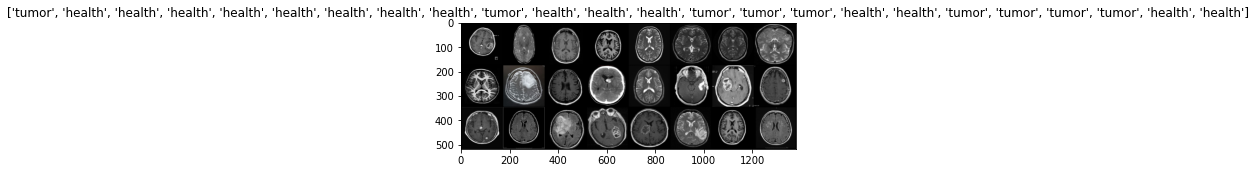

min =  0.0
median =  0.16862746
mean =  0.2189539
max =  1.0
Batch of validation data


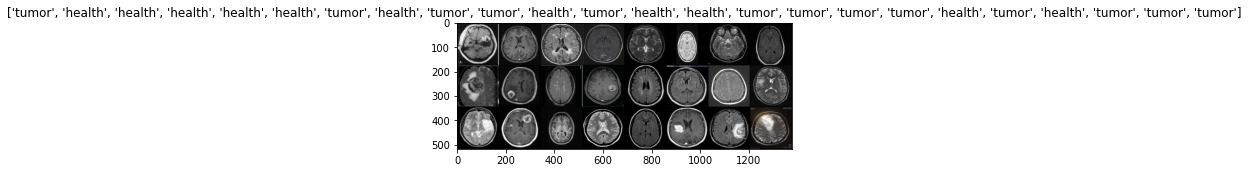

min =  0.0
median =  0.23529412
mean =  0.255966
max =  1.0
Batch of test data


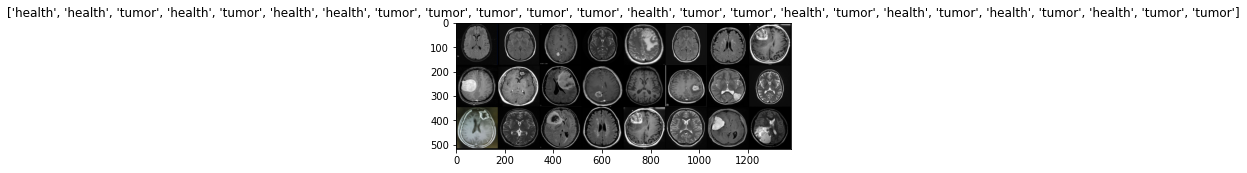

min =  0.0
median =  0.23137255
mean =  0.2468018
max =  1.0


In [ ]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))


print('Batch of validation data')
inputs, classes = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

print('Batch of test data')
inputs, classes = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

#**Parte 2 - Definindo o modelo a ser treinado e os parâmetros de treinamento**

Antes de começar a treinar uma CNN, é preciso definir o processo de treinamento e os parâmetros iniciais do modelo a ser treinado (arquitetura, learning rate, critério de otimização, etc). Não se preocupe com a primeira parte do código (2.1), de definição do processo de treinamento. Se quiser tentar melhorar a acurácia mexendo no modelo, altere os parâmetros do modelo (2.2). Você verá que neste trecho há várias linhas comentadas, dando ideias de possíveis alterações. Para a documentação sobre parâmetros de treinamento: [link](https://pytorch.org/docs/stable/optim.html)

###**2.1 - Definindo o processo de treinamento**

###**2.2 - Definindo os parâmetros do modelo e do treinamento**

In [ ]:
# Carrega uma arquitetura já conhecida: ResNet18. O parâmetro "pretrained" define o uso ou não de "Transfer Learning"
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features

# Define a sáida de tamanho 2 (Duas classes).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device) #usa a GPU, se disponível e a CPU caso contrário

# Escolha da Loss Function (critério de otimização da classificação)
criterion = nn.CrossEntropyLoss()

# Parâmetros de treinamento que podem ser alterados

# optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.0008, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.000005, momentum=0.9)

# Decay LR by a factor of "gamma" every "step_size" epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)

In [ ]:
# print(model) # mostrando a arquitetura da CNN escolhida

summary(model, (3, 170, 170)) # summarize the model 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 85, 85]           9,408
       BatchNorm2d-2           [-1, 64, 85, 85]             128
              ReLU-3           [-1, 64, 85, 85]               0
         MaxPool2d-4           [-1, 64, 43, 43]               0
            Conv2d-5           [-1, 64, 43, 43]          36,864
       BatchNorm2d-6           [-1, 64, 43, 43]             128
              ReLU-7           [-1, 64, 43, 43]               0
            Conv2d-8           [-1, 64, 43, 43]          36,864
       BatchNorm2d-9           [-1, 64, 43, 43]             128
             ReLU-10           [-1, 64, 43, 43]               0
       BasicBlock-11           [-1, 64, 43, 43]               0
           Conv2d-12           [-1, 64, 43, 43]          36,864
      BatchNorm2d-13           [-1, 64, 43, 43]             128
             ReLU-14           [-1, 64,

#**Parte 3 - Treinando a CNN**

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

# model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler, num_epochs=200)
r_model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 0.9474 Acc: 0.3920
val Loss: 0.8140 Acc: 0.3725

Epoch 1/9
----------
train Loss: 0.7924 Acc: 0.3977
val Loss: 0.7787 Acc: 0.3725

Epoch 2/9
----------
train Loss: 0.6953 Acc: 0.5170
val Loss: 0.7048 Acc: 0.3922

Epoch 3/9
----------
train Loss: 0.6457 Acc: 0.6250
val Loss: 0.6769 Acc: 0.6667

Epoch 4/9
----------
train Loss: 0.6415 Acc: 0.6080
val Loss: 0.6666 Acc: 0.6275

Epoch 5/9
----------
train Loss: 0.6353 Acc: 0.6193
val Loss: 0.6572 Acc: 0.6471

Epoch 6/9
----------
train Loss: 0.6273 Acc: 0.6250
val Loss: 0.6470 Acc: 0.5882

Epoch 7/9
----------
train Loss: 0.6220 Acc: 0.6420
val Loss: 0.6535 Acc: 0.6078

Epoch 8/9
----------
train Loss: 0.6135 Acc: 0.6591
val Loss: 0.6493 Acc: 0.6078

Epoch 9/9
----------
train Loss: 0.6185 Acc: 0.6477
val Loss: 0.6453 Acc: 0.6275

Training complete in 5m 45s
Best val Acc: 0.666667


###**Mostrando as curvas de treinamento**

Através das curvas de acurácia e de erro nos conjuntos de treinamento e validação, é possível responder algumas perguntas com relação ao treinamento: houve *overfitting*? o número de épocas não foi suficiente? Quando treinamos uma CNN, é importante observarmos essas curvas e não somente a acurácia final. Há vários textos sobre como avaliar o treinamento de um modelo a partir das curvas, veja um exemplo [aqui](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).

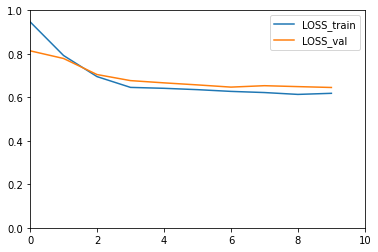

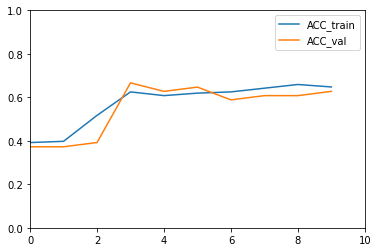

max ACC =  0.6666666666666666


In [ ]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

###**Visualizando as predições no grupo de teste**

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(r_model, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('Original')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health']
predições =  ['tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor']
matriz de confusão = 
 [[ 2  8]
 [ 3 13]]
Sensibilidade =  0.8125
Especificidade =  0.2
acc =  0.5769230769230769


# Modificações

## Versão 1

* RandomResizedCrop(input_size)
* RandomHorizontalFlip()
* ToTensor()
* Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

##data_dir = 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'
data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [ ]:
# Carrega uma arquitetura já conhecida: ResNet18. O parâmetro "pretrained" define o uso ou não de "Transfer Learning"
model_v1 = models.resnet18(pretrained=False)
num_ftrs = model_v1.fc.in_features

# Define a sáida de tamanho 2 (Duas classes).
model_v1.fc = nn.Linear(num_ftrs, 2)

model_v1 = model_v1.to(device) #usa a GPU, se disponível e a CPU caso contrário

# Escolha da Loss Function (critério de otimização da classificação)
criterion = nn.CrossEntropyLoss()

# Parâmetros de treinamento que podem ser alterados

# optimizer_ft = optim.SGD(model_v1.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v1.parameters(), lr=0.0008, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v1.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft_randstart = optim.SGD(model_v1.parameters(), lr=0.00005, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v1.parameters(), lr=0.000005, momentum=0.9)

# Decay LR by a factor of "gamma" every "step_size" epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

r_model_v1 = train_model(model_v1, criterion, optimizer_ft_randstart, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 0.7463 Acc: 0.3977
val Loss: 0.6965 Acc: 0.3725

Epoch 1/9
----------
train Loss: 0.7008 Acc: 0.5227
val Loss: 0.6778 Acc: 0.6275

Epoch 2/9
----------
train Loss: 0.6740 Acc: 0.6080
val Loss: 0.6585 Acc: 0.6275

Epoch 3/9
----------
train Loss: 0.6611 Acc: 0.6080
val Loss: 0.6493 Acc: 0.6275

Epoch 4/9
----------
train Loss: 0.6546 Acc: 0.6080
val Loss: 0.6464 Acc: 0.6275

Epoch 5/9
----------
train Loss: 0.6514 Acc: 0.6080
val Loss: 0.6468 Acc: 0.6275

Epoch 6/9
----------
train Loss: 0.6510 Acc: 0.6193
val Loss: 0.6562 Acc: 0.6471

Epoch 7/9
----------
train Loss: 0.6305 Acc: 0.6591
val Loss: 0.6644 Acc: 0.7059

Epoch 8/9
----------
train Loss: 0.6442 Acc: 0.6364
val Loss: 0.6650 Acc: 0.7059

Epoch 9/9
----------
train Loss: 0.6457 Acc: 0.6420
val Loss: 0.6574 Acc: 0.7059

Training complete in 8m 40s
Best val Acc: 0.705882


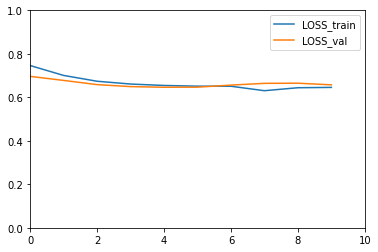

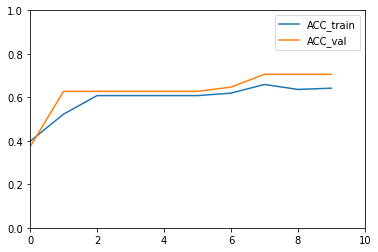

max ACC =  0.7058823529411765


In [ ]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(r_model_v1, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('Versão 1')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['health', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor']
predições =  ['tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor']
matriz de confusão = 
 [[ 3  7]
 [ 2 14]]
Sensibilidade =  0.875
Especificidade =  0.3
acc =  0.6538461538461539


## Versão 2: norma de 0.5 até 0.5

In [ ]:
# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]),
}

##data_dir = 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'
data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [ ]:
# Carrega uma arquitetura já conhecida: ResNet18. O parâmetro "pretrained" define o uso ou não de "Transfer Learning"
model_v2 = models.resnet18(pretrained=False)
num_ftrs = model_v2.fc.in_features

# Define a sáida de tamanho 2 (Duas classes).
model_v2.fc = nn.Linear(num_ftrs, 2)

model_v2 = model_v2.to(device) #usa a GPU, se disponível e a CPU caso contrário

# Escolha da Loss Function (critério de otimização da classificação)
criterion = nn.CrossEntropyLoss()

# Parâmetros de treinamento que podem ser alterados

# optimizer_ft = optim.SGD(model_v2.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v2.parameters(), lr=0.0008, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v2.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft_randstart = optim.SGD(model_v2.parameters(), lr=0.00005, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v2.parameters(), lr=0.000005, momentum=0.9)

# Decay LR by a factor of "gamma" every "step_size" epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

# Train and evaluate
r_model_v2 = train_model(model_v2, criterion, optimizer_ft_randstart, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 0.6770 Acc: 0.5909
val Loss: 0.6767 Acc: 0.6275

Epoch 1/9
----------
train Loss: 0.6675 Acc: 0.6250
val Loss: 0.6640 Acc: 0.6275

Epoch 2/9
----------
train Loss: 0.6661 Acc: 0.6136
val Loss: 0.6598 Acc: 0.6275

Epoch 3/9
----------
train Loss: 0.6577 Acc: 0.6080
val Loss: 0.6535 Acc: 0.6275

Epoch 4/9
----------
train Loss: 0.6515 Acc: 0.6080
val Loss: 0.6498 Acc: 0.6275

Epoch 5/9
----------
train Loss: 0.6474 Acc: 0.6080
val Loss: 0.6527 Acc: 0.6275

Epoch 6/9
----------
train Loss: 0.6465 Acc: 0.6250
val Loss: 0.6411 Acc: 0.6275

Epoch 7/9
----------
train Loss: 0.6397 Acc: 0.6136
val Loss: 0.6439 Acc: 0.6275

Epoch 8/9
----------
train Loss: 0.6333 Acc: 0.6250
val Loss: 0.6486 Acc: 0.6667

Epoch 9/9
----------
train Loss: 0.6272 Acc: 0.6364
val Loss: 0.6518 Acc: 0.7059

Training complete in 8m 39s
Best val Acc: 0.705882


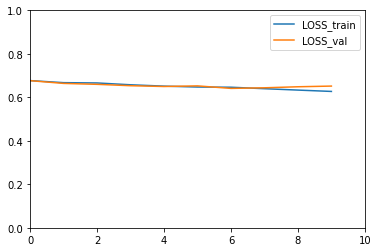

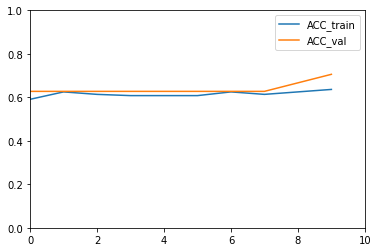

max ACC =  0.7058823529411765


In [ ]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(r_model_v2, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('Versão 2')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor']
predições =  ['tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor']
matriz de confusão = 
 [[ 3  7]
 [ 0 16]]
Sensibilidade =  1.0
Especificidade =  0.3
acc =  0.7307692307692307


## Versão 3: norma de 0 até 1

In [ ]:
# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(0, 1)
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(0, 1)
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(0, 1)
    ]),
}

##data_dir = 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'
data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [ ]:
# Carrega uma arquitetura já conhecida: ResNet18. O parâmetro "pretrained" define o uso ou não de "Transfer Learning"
model_v3 = models.resnet18(pretrained=False)
num_ftrs = model_v3.fc.in_features

# Define a sáida de tamanho 2 (Duas classes).
model.fc = nn.Linear(num_ftrs, 2)

model = model_v3.to(device) #usa a GPU, se disponível e a CPU caso contrário

# Escolha da Loss Function (critério de otimização da classificação)
criterion = nn.CrossEntropyLoss()

# Parâmetros de treinamento que podem ser alterados

# optimizer_ft = optim.SGD(model_v3.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v3.parameters(), lr=0.0008, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v3.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft_randstart = optim.SGD(model_v3.parameters(), lr=0.00005, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v3.parameters(), lr=0.000005, momentum=0.9)

# Decay LR by a factor of "gamma" every "step_size" epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

r_model_v3 = train_model(model_v3, criterion, optimizer_ft_randstart, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 7.1993 Acc: 0.0000
val Loss: 6.9394 Acc: 0.0000

Epoch 1/9
----------
train Loss: 6.8531 Acc: 0.0000
val Loss: 6.7333 Acc: 0.0000

Epoch 2/9
----------
train Loss: 6.3342 Acc: 0.0000
val Loss: 6.3794 Acc: 0.0000

Epoch 3/9
----------
train Loss: 5.7499 Acc: 0.2670
val Loss: 5.9627 Acc: 0.5882

Epoch 4/9
----------
train Loss: 5.1090 Acc: 0.6080
val Loss: 5.4702 Acc: 0.6275

Epoch 5/9
----------
train Loss: 4.5029 Acc: 0.6080
val Loss: 4.9850 Acc: 0.6275

Epoch 6/9
----------
train Loss: 3.9106 Acc: 0.6080
val Loss: 4.3731 Acc: 0.6275

Epoch 7/9
----------
train Loss: 3.3187 Acc: 0.6080
val Loss: 3.5840 Acc: 0.6275

Epoch 8/9
----------
train Loss: 2.8805 Acc: 0.6080
val Loss: 2.8150 Acc: 0.6275

Epoch 9/9
----------
train Loss: 2.4219 Acc: 0.6080
val Loss: 2.1959 Acc: 0.6275

Training complete in 8m 33s
Best val Acc: 0.627451


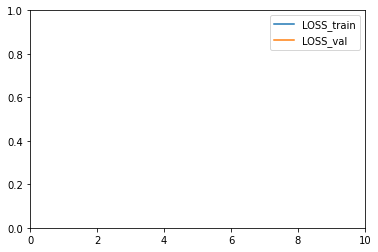

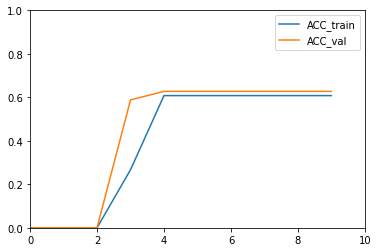

max ACC =  0.6274509803921569


In [ ]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(r_model_v3, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('Versão 3')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health']
predições =  ['tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor']
matriz de confusão = 
 [[ 0 10]
 [ 0 16]]
Sensibilidade =  1.0
Especificidade =  0.0
acc =  0.6153846153846154


## Versão 4

Modelo que varia entre 5 otimizadores.

In [ ]:
# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

##data_dir = 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'
data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [ ]:
# Carrega uma arquitetura já conhecida: ResNet18. O parâmetro "pretrained" define o uso ou não de "Transfer Learning"
model_v4 = models.resnet18(pretrained=False)
num_ftrs = model_v4.fc.in_features

# Define a sáida de tamanho 2 (Duas classes).
model_v4.fc = nn.Linear(num_ftrs, 2)

model_v4 = model_v4.to(device) #usa a GPU, se disponível e a CPU caso contrário

# Escolha da Loss Function (critério de otimização da classificação)
criterion = nn.CrossEntropyLoss()

optimizer = []

optimizer.append(optim.SGD(model_v4.parameters(), lr=0.001, momentum=0.9))
optimizer.append(optim.SGD(model_v4.parameters(), lr=0.0008, momentum=0.9))
optimizer.append(optim.SGD(model_v4.parameters(), lr=0.0001, momentum=0.9))
optimizer.append(optim.SGD(model_v4.parameters(), lr=0.00005, momentum=0.9))
optimizer.append(optim.SGD(model_v4.parameters(), lr=0.000005, momentum=0.9))

Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Epoch 0/9
----------
train Loss: 0.7329 Acc: 0.6023
val Loss: 0.7418 Acc: 0.3725

Epoch 1/9
----------
train Loss: 0.7268 Acc: 0.5284
val Loss: 0.6506 Acc: 0.6275

Epoch 2/9
----------
train Loss: 0.7080 Acc: 0.6136
val Loss: 0.6614 Acc: 0.6275

Epoch 3/9
----------
train Loss: 0.6427 Acc: 0.6136
val Loss: 0.6097 Acc: 0.6275

Epoch 4/9
----------
train Loss: 0.6145 Acc: 0.6420
val Loss: 0.6103 Acc: 0.6863

Epoch 5/9
----------
train Loss: 0.5783 Acc: 0.7102
val Loss: 0.6046 Acc: 0.6667

Epoch 6/9
----------
train Loss: 0.5852 Acc: 0.7102
val Loss: 0.5950 Acc: 0.7059

Epoch 7/9
----------
train Loss: 0.5633 Acc: 0.7216
val Loss: 0.6928 Acc: 0.5686

Epoch 8/9
----------
train Loss: 0.5687 Acc: 0.6989
val Loss: 0.5904 Acc: 0.6471

Epoch 9/9
----------
train Loss: 0.6444 Acc: 0.6761
val Loss: 0.6095 Acc: 0.6863

Training complete in 8m 30s
Best val Acc: 0.705882


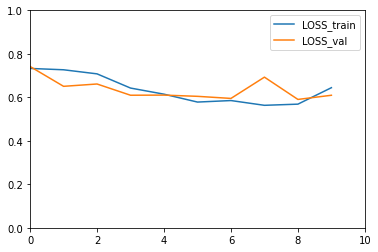

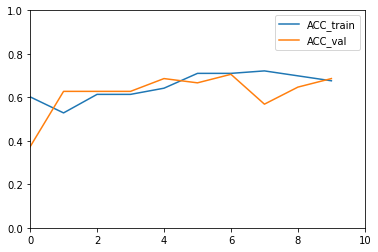

max ACC =  0.7058823529411765

 Conjunto de Teste 

labels =  ['tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health']
predições =  ['tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health']
matriz de confusão = 
 [[10  0]
 [ 2 14]]
Sensibilidade =  0.875
Especificidade =  1.0
acc =  0.9230769230769231



Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0008
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Epoch 0/9
----------
train Loss: 0.5620 Acc: 0.7045
val Loss: 0.6407 Acc: 0.6078

Epoch 1/9
----------
train Loss: 0.5456 Acc: 0.7443
val Loss: 0.5815 Acc: 0.7059

Epoch 2/9
----------
trai

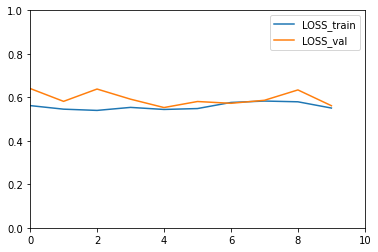

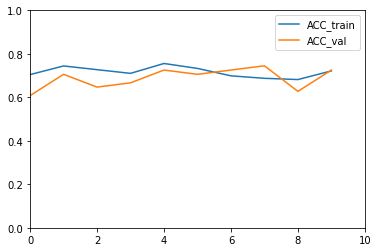

max ACC =  0.7450980392156863

 Conjunto de Teste 

labels =  ['tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health']
predições =  ['tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health']
matriz de confusão = 
 [[10  0]
 [ 4 12]]
Sensibilidade =  0.75
Especificidade =  1.0
acc =  0.8461538461538461



Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Epoch 0/9
----------
train Loss: 0.5712 Acc: 0.7614
val Loss: 0.5952 Acc: 0.7059

Epoch 1/9
----------
train Loss: 0.5046 Acc: 0.7500
val Loss: 0.5999 Acc: 0.7059

Epoch 2/9
----------
tra

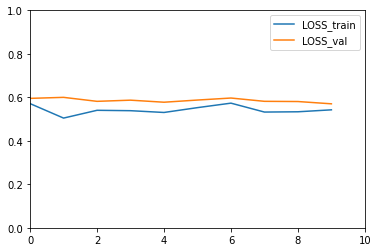

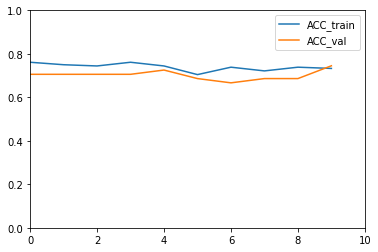

max ACC =  0.7450980392156863

 Conjunto de Teste 

labels =  ['tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health']
predições =  ['tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'health', 'health', 'health']
matriz de confusão = 
 [[10  0]
 [ 3 13]]
Sensibilidade =  0.8125
Especificidade =  1.0
acc =  0.8846153846153846



Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    lr: 5e-05
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Epoch 0/9
----------
train Loss: 0.5270 Acc: 0.7273
val Loss: 0.5784 Acc: 0.6863

Epoch 1/9
----------
train Loss: 0.5496 Acc: 0.7216
val Loss: 0.5728 Acc: 0.7059

Epoch 2/9
----------
tra

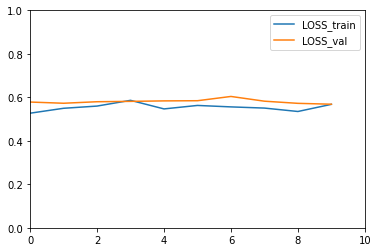

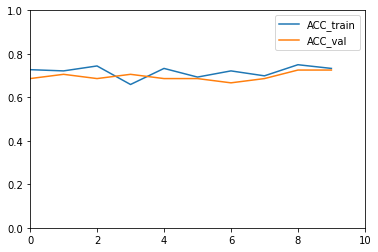

max ACC =  0.7254901960784313

 Conjunto de Teste 

labels =  ['tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor']
predições =  ['tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor']
matriz de confusão = 
 [[10  0]
 [ 3 13]]
Sensibilidade =  0.8125
Especificidade =  1.0
acc =  0.8846153846153846



Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    lr: 5e-06
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Epoch 0/9
----------
train Loss: 0.5257 Acc: 0.7784
val Loss: 0.5740 Acc: 0.7059

Epoch 1/9
----------
train Loss: 0.5487 Acc: 0.7386
val Loss: 0.5789 Acc: 0.6863

Epoch 2/9
----------
tra

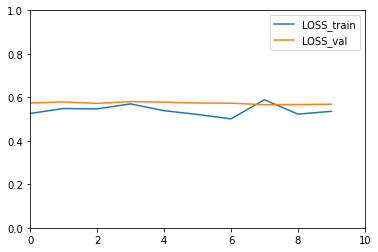

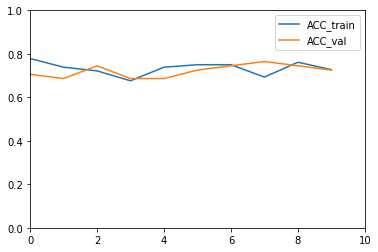

max ACC =  0.7647058823529411

 Conjunto de Teste 

labels =  ['tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor']
predições =  ['tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor']
matriz de confusão = 
 [[10  0]
 [ 3 13]]
Sensibilidade =  0.8125
Especificidade =  1.0
acc =  0.8846153846153846





In [ ]:
for opt in range(len(optimizer)):
  print('Optimizer: ', optimizer[opt])

  LOSS_train = []
  LOSS_val = []
  ACC_train = []
  ACC_val = []

  exp_lr_scheduler = lr_scheduler.StepLR(optimizer[opt], step_size=100, gamma=0.5)

  op_model_v4 = train_model(model_v4, criterion, optimizer[opt], exp_lr_scheduler, num_epochs=EPOCHS)

  LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
  plt.plot(LOSSES[:,:2])
  plt.axis([0, len(LOSSES), 0, 1])
  plt.legend(['LOSS_train','LOSS_val'])
  plt.show()
  plt.plot(LOSSES[:,2:])
  plt.axis([0, len(LOSSES), 0, 1])
  plt.legend(['ACC_train','ACC_val'])
  plt.show()
  print('max ACC = ', LOSSES[:,3:].max())

  test_group_len = 26
  PREDICTED, LABEL = predic_model(op_model_v4, plot_img = False, num_images=test_group_len)

  test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
  test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

  print('\n Conjunto de Teste \n')
  CM_test = confusion_matrix(LABEL, PREDICTED)
  Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
  Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
  print('labels = ', LABEL)
  print('predições = ', PREDICTED)
  print('matriz de confusão = \n', CM_test)
  print('Sensibilidade = ', Sensibilidade)
  print('Especificidade = ', Especificidade)
  print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)
  print('\n\n')

  title = 'Versão 4 com opitimizer ' + str(opt+1)
  string_all.append(title)
  sensibilidade_all.append(Sensibilidade)
  especificidade_all.append(Especificidade)
  acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

## Finetuning the resnet18

In [ ]:
# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

##data_dir = 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'
data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [ ]:
# https://www.kaggle.com/vvijaybabu/2-class-classification-resnet-18-kernel

ngpus_per_node = torch.cuda.device_count()
feature_extract = False # if true this will not re-train the model, but only change the last stage
use_pretrained = True

# create model
print("=> creating model ")
model = models.resnet18(pretrained=use_pretrained) #pretrained=use_pretrained

if feature_extract:
    for param in model.parameters():
        param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)            
model.to(device)

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda(ngpus_per_node)

modeldir = os.path.join('../data/', 'train')
# Data loading code
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

#print("length", train_dataset.__len__)

#load the classification results
#now based on results, move the image to either of 2 classification bucket
#if dir "cactus" or "nocactus" is not present, create it

params_to_update = []

if feature_extract:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda(ngpus_per_node)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

=> creating model 


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

# Train and evaluate
model_resnet = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 0.6497 Acc: 0.5909
val Loss: 0.5972 Acc: 0.6863

Epoch 1/9
----------
train Loss: 0.5556 Acc: 0.7273
val Loss: 0.5179 Acc: 0.7843

Epoch 2/9
----------
train Loss: 0.5243 Acc: 0.7273
val Loss: 0.4199 Acc: 0.8235

Epoch 3/9
----------
train Loss: 0.4601 Acc: 0.7955
val Loss: 0.3880 Acc: 0.8431

Epoch 4/9
----------
train Loss: 0.4144 Acc: 0.8466
val Loss: 0.3320 Acc: 0.8431

Epoch 5/9
----------
train Loss: 0.3903 Acc: 0.8466
val Loss: 0.3111 Acc: 0.8431

Epoch 6/9
----------
train Loss: 0.3341 Acc: 0.8864
val Loss: 0.3045 Acc: 0.9020

Epoch 7/9
----------
train Loss: 0.2849 Acc: 0.8977
val Loss: 0.2953 Acc: 0.9216

Epoch 8/9
----------
train Loss: 0.3019 Acc: 0.8807
val Loss: 0.2923 Acc: 0.9020

Epoch 9/9
----------
train Loss: 0.2910 Acc: 0.8864
val Loss: 0.2856 Acc: 0.8824

Training complete in 8m 33s
Best val Acc: 0.921569


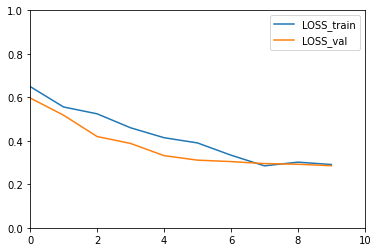

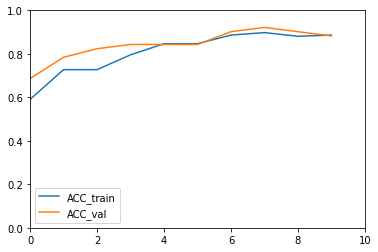

max ACC =  0.9215686274509803


In [ ]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model_resnet, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('Finituning the resnet18')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor']
predições =  ['health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor']
matriz de confusão = 
 [[10  0]
 [ 3 13]]
Sensibilidade =  0.8125
Especificidade =  1.0
acc =  0.8846153846153846


## Finetuning the convnet

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_convnet = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 0.7718 Acc: 0.5114
val Loss: 0.6394 Acc: 0.7255

Epoch 1/9
----------
train Loss: 0.6347 Acc: 0.6818
val Loss: 0.5859 Acc: 0.6667

Epoch 2/9
----------
train Loss: 0.5474 Acc: 0.6989
val Loss: 0.4760 Acc: 0.7843

Epoch 3/9
----------
train Loss: 0.5158 Acc: 0.7614
val Loss: 0.4050 Acc: 0.7647

Epoch 4/9
----------
train Loss: 0.4434 Acc: 0.7898
val Loss: 0.3553 Acc: 0.8431

Epoch 5/9
----------
train Loss: 0.3290 Acc: 0.9034
val Loss: 0.3885 Acc: 0.7843

Epoch 6/9
----------
train Loss: 0.3213 Acc: 0.8864
val Loss: 0.2642 Acc: 0.8824

Epoch 7/9
----------
train Loss: 0.3045 Acc: 0.8580
val Loss: 0.2661 Acc: 0.8824

Epoch 8/9
----------
train Loss: 0.2905 Acc: 0.8977
val Loss: 0.2689 Acc: 0.9020

Epoch 9/9
----------
train Loss: 0.2631 Acc: 0.8977
val Loss: 0.2786 Acc: 0.9020

Training complete in 8m 33s
Best val Acc: 0.901961


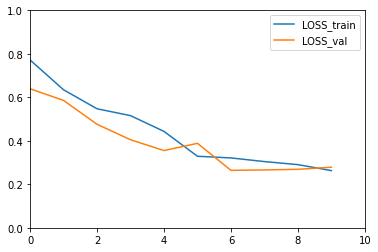

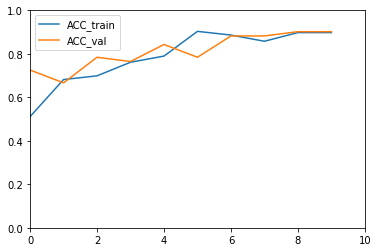

max ACC =  0.9019607843137255


In [ ]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model_convnet, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('Finituning the convnet')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'health']
predições =  ['health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'health']
matriz de confusão = 
 [[10  0]
 [ 2 14]]
Sensibilidade =  0.875
Especificidade =  1.0
acc =  0.9230769230769231


## ConvNet as fixed feature extractor

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_conv2 = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 0.7146 Acc: 0.5398
val Loss: 0.7245 Acc: 0.6275

Epoch 1/9
----------
train Loss: 0.7277 Acc: 0.5795
val Loss: 0.7861 Acc: 0.3922

Epoch 2/9
----------
train Loss: 0.6413 Acc: 0.6705
val Loss: 0.5870 Acc: 0.7059

Epoch 3/9
----------
train Loss: 0.5910 Acc: 0.6648
val Loss: 0.5940 Acc: 0.6863

Epoch 4/9
----------
train Loss: 0.5431 Acc: 0.7159
val Loss: 0.4945 Acc: 0.7255

Epoch 5/9
----------
train Loss: 0.5607 Acc: 0.6875
val Loss: 0.4713 Acc: 0.8235

Epoch 6/9
----------
train Loss: 0.5114 Acc: 0.7216
val Loss: 0.4417 Acc: 0.7843

Epoch 7/9
----------
train Loss: 0.5007 Acc: 0.7727
val Loss: 0.4473 Acc: 0.8039

Epoch 8/9
----------
train Loss: 0.4677 Acc: 0.7784
val Loss: 0.4444 Acc: 0.8431

Epoch 9/9
----------
train Loss: 0.4342 Acc: 0.8295
val Loss: 0.4540 Acc: 0.8039

Training complete in 3m 34s
Best val Acc: 0.843137


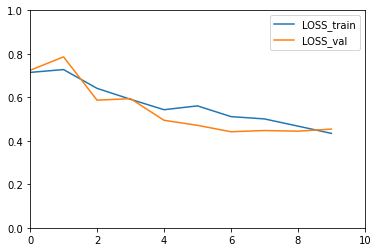

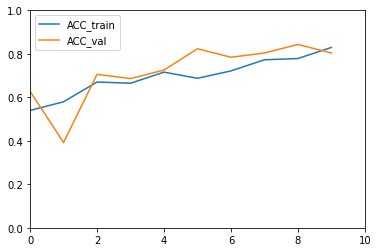

max ACC =  0.8431372549019608


In [ ]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model_conv2, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('ConvNet as fixed feature extractor')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'health', 'tumor', 'tumor']
predições =  ['tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'health', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor']
matriz de confusão = 
 [[ 9  1]
 [ 2 14]]
Sensibilidade =  0.875
Especificidade =  0.9
acc =  0.8846153846153846


## Adicionando camadas

Adiciona algumas camadas ao modelo pré-treinado:

* Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
* Sequencial()
* AdaptiveAvgPool2d(1)
* model_ft.fc.out_features = 200

In [ ]:
model_ft = models.resnet18()
model_ft.conv1 = nn.Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
model_ft.maxpool = nn.Sequential()
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
model_ft.fc.out_features = 200

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opoosed to before.
optimizer_conv = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_camadas = train_model(model_ft, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 6.2326 Acc: 0.1989
val Loss: 4.7856 Acc: 0.6275

Epoch 1/9
----------
train Loss: 1.7320 Acc: 0.6080
val Loss: 1.1104 Acc: 0.6275

Epoch 2/9
----------
train Loss: 0.7414 Acc: 0.5682
val Loss: 0.6749 Acc: 0.6471

Epoch 3/9
----------
train Loss: 0.6762 Acc: 0.6023
val Loss: 0.6561 Acc: 0.6275

Epoch 4/9
----------
train Loss: 0.6259 Acc: 0.6761
val Loss: 0.6838 Acc: 0.5490

Epoch 5/9
----------
train Loss: 0.6909 Acc: 0.5966
val Loss: 0.6643 Acc: 0.6078

Epoch 6/9
----------
train Loss: 0.6408 Acc: 0.6307
val Loss: 0.6574 Acc: 0.6863

Epoch 7/9
----------
train Loss: 0.6134 Acc: 0.6818
val Loss: 0.6467 Acc: 0.7255

Epoch 8/9
----------
train Loss: 0.5969 Acc: 0.6875
val Loss: 0.6460 Acc: 0.7255

Epoch 9/9
----------
train Loss: 0.6243 Acc: 0.6818
val Loss: 0.6535 Acc: 0.6863

Training complete in 110m 34s
Best val Acc: 0.725490


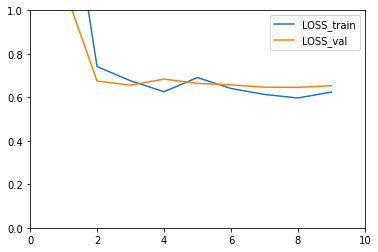

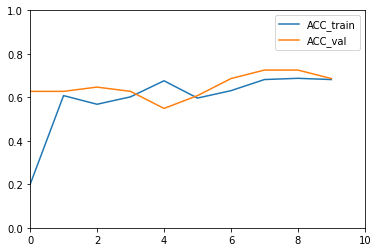

max ACC =  0.7254901960784313


In [ ]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model_camadas, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('Adicionando camadas')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health']
predições =  ['tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health']
matriz de confusão = 
 [[ 4  6]
 [ 1 15]]
Sensibilidade =  0.9375
Especificidade =  0.4
acc =  0.7307692307692307


## Modelo Geral

Cria um modelo como algumas funções adicionais.

Adaptatação de código obtido em:

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

### squeezenet

In [ ]:
# Models to choose from [squeezenet, vgg, alexnet, resnet, densenet, inception]
model_name = "squeezenet"

# Print the model we just instantiated
#print(model_ft)

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

#*******************************************************************************

# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

#*******************************************************************************

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#*******************************************************************************

LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth



Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.squeeze.weight
	 features.3.squeeze.bias
	 features.3.expand1x1.weight
	 features.3.expand1x1.bias
	 features.3.expand3x3.weight
	 features.3.expand3x3.bias
	 features.4.squeeze.weight
	 features.4.squeeze.bias
	 features.4.expand1x1.weight
	 features.4.expand1x1.bias
	 features.4.expand3x3.weight
	 features.4.expand3x3.bias
	 features.5.squeeze.weight
	 features.5.squeeze.bias
	 features.5.expand1x1.weight
	 features.5.expand1x1.bias
	 features.5.expand3x3.weight
	 features.5.expand3x3.bias
	 features.7.squeeze.weight
	 features.7.squeeze.bias
	 features.7.expand1x1.weight
	 features.7.expand1x1.bias
	 features.7.expand3x3.weight
	 features.7.expand3x3.bias
	 features.8.squeeze.weight
	 features.8.squeeze.bias
	 features.8.expand1x1.weight
	 features.8.expand1x1.bias
	 features.8.expand3x3.weight
	 features.8.expand3x3.bias
	 features.9.squeeze.weight
	 features.9.squeeze.bias
	 features.9.expand1x1.weight
	 features

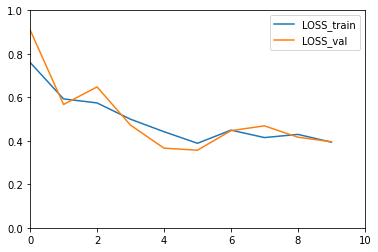

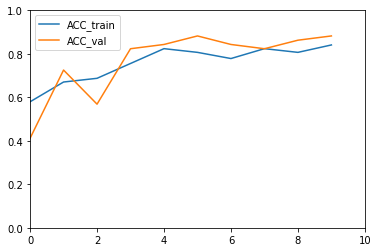

max ACC =  0.8823529411764706


In [ ]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model_ft, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('squeezenet')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health']
predições =  ['tumor', 'health', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health']
matriz de confusão = 
 [[10  0]
 [ 2 14]]
Sensibilidade =  0.875
Especificidade =  1.0
acc =  0.9230769230769231


### vgg

In [ ]:
# Models to choose from [squeezenet, vgg, alexnet, resnet, densenet, inception]
model_name = "vgg"

# Print the model we just instantiated
#print(model_ft)

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

#*******************************************************************************

# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

#*******************************************************************************

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#*******************************************************************************

LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth



Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias
Epoch 0/9
----------
train Loss: 0.7210 Acc: 0.5057
val Loss: 0.6101 Acc: 0.6863

Epoch 1/9
----------
train Loss: 0.5919 Acc: 0.6761
val Loss: 0.5753 Acc: 0.7647

Epoch 2/9
----------
train Loss: 0.5420 Acc: 0.6989
val Loss: 0.

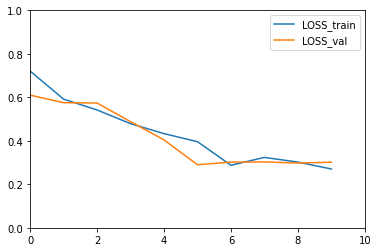

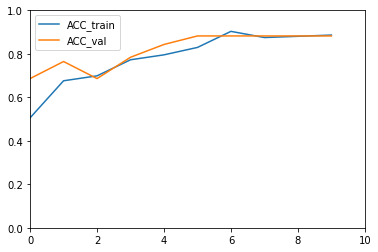

max ACC =  0.8823529411764706


In [ ]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model_ft, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('vvg')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health']
predições =  ['tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'health', 'health']
matriz de confusão = 
 [[ 9  1]
 [ 1 15]]
Sensibilidade =  0.9375
Especificidade =  0.9
acc =  0.9230769230769231


### alexnet

In [ ]:
# Models to choose from [squeezenet, vgg, alexnet, resnet, densenet, inception]
model_name = "alexnet"

# Print the model we just instantiated
#print(model_ft)

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

#*******************************************************************************

# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

#*******************************************************************************

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#*******************************************************************************

LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias
Epoch 0/9
----------
train Loss: 0.7222 Acc: 0.5625
val Loss: 0.4889 Acc: 0.8039

Epoch 1/9
----------
train Loss: 0.6063 Acc: 0.6648
val Loss: 0.4535 Acc: 0.8039

Epoch 2/9
----------
train Loss: 0.4611 Acc: 0.7955
val Loss: 0.9718 Acc: 0.5294

Epoch 3/9
----------
train Loss: 0.4983 Acc: 0.7727
val Loss: 0.7827 Acc: 0.5490

Epoch 4/9
----------
train Loss: 0.4674 Acc: 0.7614
val Loss: 0.3277 Acc: 0.9020

Epoch 5/9
----------
train Loss: 0.3842 Acc: 0.8466
val Loss: 0.2601 Acc: 0.9216

Epoch 6/9
----------
train Loss: 0.4419 Acc: 0.8239
val Loss: 0.5581 Acc: 0.6275

Epoch 7/9
----------
train Loss: 0.3983 Acc: 0.8352
val Loss: 0.4021 Acc: 0.8431

Epoch 8/

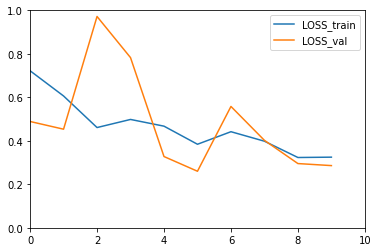

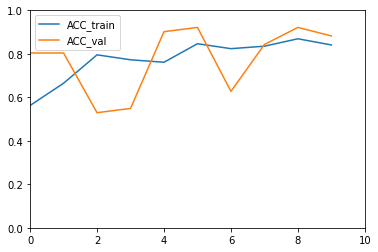

max ACC =  0.9215686274509803


In [ ]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model_ft, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('alexnet')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['health', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health']
predições =  ['health', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health']
matriz de confusão = 
 [[10  0]
 [ 1 15]]
Sensibilidade =  0.9375
Especificidade =  1.0
acc =  0.9615384615384616


### resnet

In [ ]:
# Models to choose from [squeezenet, vgg, alexnet, resnet, densenet, inception]
model_name = "resnet"

# Print the model we just instantiated
#print(model_ft)

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

#*******************************************************************************

# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

#*******************************************************************************

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#*******************************************************************************

LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

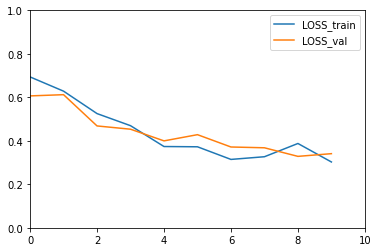

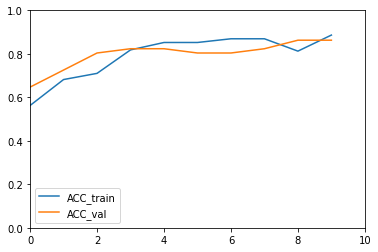

max ACC =  0.8627450980392157


In [ ]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model_ft, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('resnet')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health']
predições =  ['health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health']
matriz de confusão = 
 [[10  0]
 [ 1 15]]
Sensibilidade =  0.9375
Especificidade =  1.0
acc =  0.9615384615384616


### densenet

In [67]:
# Models to choose from [squeezenet, vgg, alexnet, resnet, densenet, inception]
model_name = "densenet"

# Print the model we just instantiated
#print(model_ft)

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

#*******************************************************************************

# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

#*******************************************************************************

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#*******************************************************************************

LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS)

Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

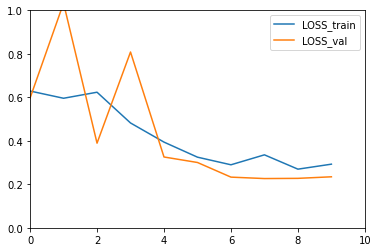

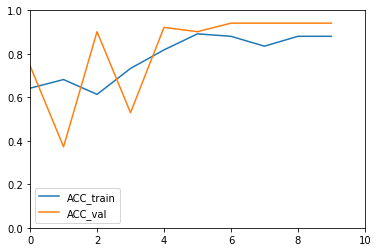

max ACC =  0.9411764705882353


In [63]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [64]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model_ft, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('densent')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor']
predições =  ['health', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor']
matriz de confusão = 
 [[ 9  1]
 [ 1 15]]
Sensibilidade =  0.9375
Especificidade =  0.9
acc =  0.9230769230769231


# Resultados

In [70]:
for i in range(len(string_all)):
  print(string_all[i])
  print('Sensibilidade: ', sensibilidade_all[i])
  print('Especificidade: ', especificidade_all[i])
  print('Accuracy: ', acc_all[i])
  print('\n')

Original
Sensibilidade:  0.8125
Especificidade:  0.2
Accuracy:  0.5769230769230769


Versão 1
Sensibilidade:  0.875
Especificidade:  0.3
Accuracy:  0.6538461538461539


Versão 2
Sensibilidade:  1.0
Especificidade:  0.3
Accuracy:  0.7307692307692307


Versão 3
Sensibilidade:  1.0
Especificidade:  0.0
Accuracy:  0.6153846153846154


Versão 4 com opitimizer 1
Sensibilidade:  0.875
Especificidade:  1.0
Accuracy:  0.9230769230769231


Versão 4 com opitimizer 2
Sensibilidade:  0.75
Especificidade:  1.0
Accuracy:  0.8461538461538461


Versão 4 com opitimizer 3
Sensibilidade:  0.8125
Especificidade:  1.0
Accuracy:  0.8846153846153846


Versão 4 com opitimizer 4
Sensibilidade:  0.8125
Especificidade:  1.0
Accuracy:  0.8846153846153846


Versão 4 com opitimizer 5
Sensibilidade:  0.8125
Especificidade:  1.0
Accuracy:  0.8846153846153846


Finituning the resnet18
Sensibilidade:  0.8125
Especificidade:  1.0
Accuracy:  0.8846153846153846


Finituning the convnet
Sensibilidade:  0.875
Especificidade:

## Sensibilidade

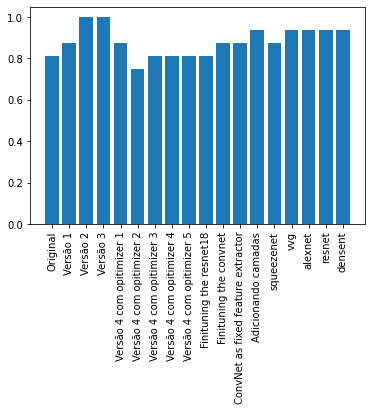

In [71]:
import matplotlib.pyplot as plt

plt.bar(string_all,sensibilidade_all)
plt.xticks(rotation=90)
plt.show()

## Especificidade

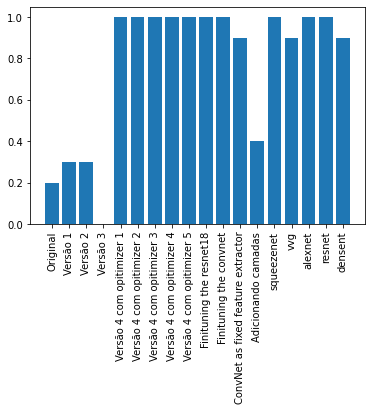

In [72]:
import matplotlib.pyplot as plt

plt.bar(string_all,especificidade_all)
plt.xticks(rotation=90)
plt.show()

## Accuracy

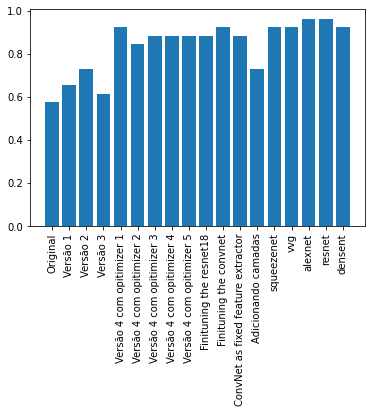

In [74]:
import matplotlib.pyplot as plt

plt.bar(string_all,acc_all)
plt.xticks(rotation=90)
plt.show()